In [82]:
#import jax.numpy as np
#from jax import pmap
import numpy as np
from maxnorm.maxnorm_completion import *
from maxnorm.tenalg import *
from maxnorm.graphs import *
import sparse
from itertools import product
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='times')

import matplotlib
matplotlib.rcParams['text.usetex'] = False

In [84]:
# create random, low-rank tensor
t = 4
n = 400
r = 3
#delta = 0.1
const = 24
sigma = 0.0
ndata =  const * r * t * n * np.log10(n)
U = kr_random(n, t, r, rvs='unif')
U = kr_rescale(U, np.sqrt(n**t), 'hs')
norm_true = np.sqrt(kr_dot(U, U) / n**t)
#U = [np.random.randn(n, r) for i in range(t)]
print("n data: %.2e" % ndata)
print("n data ** t/2: %.2e" % int(const * r * n**(t/2) * np.log10(n)))
print("true norm: %.2e" % norm_true)

n data: 3.00e+05
n data ** t/2: 3.00e+07
true norm: 1.00e+00


In [85]:
qnorm_true = max_qnorm_ub(U)
print(qnorm_true)
print(r**(t/2))

35.775909060966384
9.0


In [86]:
expander = nx.random_regular_graph(12, n)
#expander = nx.chordal_cycle_graph(n)
observation_mask = obs_mask_expander(expander, t)
#observation_mask = obs_mask_iid(tuple([n for i in range(t)]), ndata * n**(-t))

In [87]:
from run_sweep_iid import generate_data


data = generate_data(observation_mask, U, sigma)
clean_data_rmse = np.sqrt(loss(U, data) / data.nnz)
print(data.nnz)
print(ndata)
print(n**t)
print("%0.1e%%" % (float(data.nnz) / n**t * 100))

691200
299757.31100098125
25600000000
2.7e-03%


In [88]:
np.sqrt(data.sum()**2 / data.nnz)

1.1068192192917812

In [89]:
data.coords

array([[  0,   0,   0, ..., 399, 399, 399],
       [ 85,  85,  85, ..., 382, 382, 382],
       [  0,   0,   0, ..., 399, 399, 399],
       [ 85, 121, 130, ..., 336, 351, 382]])

In [90]:
delta = max(1.5 * sigma, 0.05)
#np.sqrt(np.sum((data.data - clean_data)**2)) * 2 / np.sqrt(data.nnz) * 1.5

print("rms of data:        %f" % clean_data_rmse)
print("delta parameter:    %f" % delta)
print("rmse of U true:     %f" % np.sqrt(loss(U, data) / data.nnz))

rms of data:        0.000000
delta parameter:    0.050000
rmse of U true:     0.000000


In [91]:
# from tensorly.contrib.sparse.decomposition import parafac

# mask = data != 0
# core, factors = parafac(data, r, mask=mask, init='random', verbose=True, tol=1e-3, n_iter_max=8)
# scale_mat = np.diag(core.todense()**(1/t))
# U = [factors[i].todense() @ scale_mat for i in range(t)]

#Unew = [np.hstack((U, np.random.randn(n,r**(t-1)))) for U in Unew2]

In [92]:
# %autoreload
# Unew1, cost_arr = tensor_completion_alt_min(data, 2 * r**t,
#                                             #sgd=True, sgd_batch_size=2000,
#                                             #U0 = Unew2,
#                                             init='svdrand', 
#                                             tol=1e-10, max_iter=10*n, verbosity=2)
# # Unew1, cost_arr = tensor_completion_fro(data, 2 * r**t, delta,
# #                                             #sgd=True, sgd_batch_size=2000,
# #                                             #U0 = Unew2,
# #                                             init='svdrand', 
# #                                             tol=1e-10, max_iter=10*n, verbosity=2)

In [93]:
def print_factor_norms(U):
    print("fro:   " + str([np.linalg.norm(Ui,'fro')**2 for Ui in U]))
    print("2-inf: " + str([np.max(np.linalg.norm(Ui, axis=1)) for Ui in U]))

print_factor_norms(kr_balance_factors(U))

fro:   [911.2473264661509, 911.2473264661509, 911.2473264661509, 911.2473264661504]
2-inf: [2.4584362152734265, 2.4915247411410437, 2.461740945472573, 2.3740235045510847]


In [94]:
12**4

20736

In [95]:
#Uinit = kr_rescale(Unew1, np.sqrt(np.product(data.shape) * data.sum() ** 2 / data.nnz), 'hs')
Uinit = kr_balance_factors(Unew1)

NameError: name 'Unew1' is not defined

In [96]:
[np.linalg.norm(Ui, axis=1) for Ui in Uinit]

NameError: name 'Uinit' is not defined

In [97]:
%autoreload
Unew2, cost_arr, max_qnorm_arr, gen_err_arr = tensor_completion_maxnorm(data, 20, delta * np.sqrt(data.nnz), epsilon=1e-2,
                                            init='svdrand',
                                            kappa=100, beta=1, 
                                            tol=1e-10, inner_tol=1e-12, max_iter=300, inner_max_iter=10, 
                                            verbosity=2,
                                            rebalance=True, return_extra=True, Utrue=U)

Initial cost: 3.162e+07
Initial qnorm_ub: 8.332e-01
|| r || = 1.007e+00, delta = 5.000e-02
Entering inner loop for factor 0
qnorm_factr = 1.107e+00
Entering inner loop for factor 1
qnorm_factr = 2.685e+01
Entering inner loop for factor 2
qnorm_factr = 2.918e+02
Entering inner loop for factor 3
qnorm_factr = 2.906e+02

Iteration 0 complete


scaled || r || = 1.001e+00, delta = 5.000e-02
Max-qnorm upper bound: 3.445e+02
Cost function:         3.123e+07
gen_errr = 1.000e+00


Entering inner loop for factor 0
qnorm_factr = 1.231e+02
Entering inner loop for factor 1
qnorm_factr = 8.062e+01
Entering inner loop for factor 2
qnorm_factr = 7.787e+01
Entering inner loop for factor 3
qnorm_factr = 7.958e+01

Iteration 1 complete


scaled || r || = 9.890e-01, delta = 5.000e-02
Max-qnorm upper bound: 3.966e+02
Cost function:         3.047e+07
gen_errr = 1.000e+00


Entering inner loop for factor 0
qnorm_factr = 1.266e+02
Entering inner loop for factor 1
qnorm_factr = 8.958e+01
Entering inner loop f

Entering inner loop for factor 1
qnorm_factr = 9.637e+01
Entering inner loop for factor 2
qnorm_factr = 1.099e+02
Entering inner loop for factor 3
qnorm_factr = 1.204e+02

Iteration 18 complete


scaled || r || = 3.632e-02, delta = 5.000e-02
Max-qnorm upper bound: 4.133e+02
Cost function:         9.279e+02
gen_errr = 1.975e-01


Entering inner loop for factor 0
qnorm_factr = 6.068e+01
Entering inner loop for factor 1
qnorm_factr = 8.957e+01
Entering inner loop for factor 2
qnorm_factr = 1.038e+02
Entering inner loop for factor 3
qnorm_factr = 1.155e+02

Iteration 19 complete


scaled || r || = 3.359e-02, delta = 5.000e-02
Max-qnorm upper bound: 3.853e+02
Cost function:         8.343e+02
gen_errr = 1.896e-01


Entering inner loop for factor 0
qnorm_factr = 5.733e+01
Entering inner loop for factor 1
qnorm_factr = 8.421e+01
Entering inner loop for factor 2
qnorm_factr = 9.825e+01
Entering inner loop for factor 3
qnorm_factr = 1.108e+02

Iteration 20 complete


scaled || r || = 3.121e-02, 


Iteration 36 complete


scaled || r || = 1.615e-02, delta = 5.000e-02
Max-qnorm upper bound: 2.069e+02
Cost function:         3.546e+02
gen_errr = 1.289e-01


Entering inner loop for factor 0
qnorm_factr = 3.472e+01
Entering inner loop for factor 1
qnorm_factr = 4.992e+01
Entering inner loop for factor 2
qnorm_factr = 6.084e+01
Entering inner loop for factor 3
qnorm_factr = 8.245e+01

Iteration 37 complete


scaled || r || = 1.572e-02, delta = 5.000e-02
Max-qnorm upper bound: 2.019e+02
Cost function:         3.448e+02
gen_errr = 1.270e-01


Entering inner loop for factor 0
qnorm_factr = 3.399e+01
Entering inner loop for factor 1
qnorm_factr = 4.884e+01
Entering inner loop for factor 2
qnorm_factr = 5.960e+01
Entering inner loop for factor 3
qnorm_factr = 8.163e+01

Iteration 38 complete


scaled || r || = 1.531e-02, delta = 5.000e-02
Max-qnorm upper bound: 1.971e+02
Cost function:         3.354e+02
gen_errr = 1.252e-01


Entering inner loop for factor 0
qnorm_factr = 3.328e+01
Enterin

Entering inner loop for factor 1
qnorm_factr = 3.631e+01
Entering inner loop for factor 2
qnorm_factr = 4.550e+01
Entering inner loop for factor 3
qnorm_factr = 7.229e+01

Iteration 55 complete


scaled || r || = 1.084e-02, delta = 5.000e-02
Max-qnorm upper bound: 1.431e+02
Cost function:         2.394e+02
gen_errr = 1.030e-01


Entering inner loop for factor 0
qnorm_factr = 2.507e+01
Entering inner loop for factor 1
qnorm_factr = 3.583e+01
Entering inner loop for factor 2
qnorm_factr = 4.496e+01
Entering inner loop for factor 3
qnorm_factr = 7.189e+01

Iteration 56 complete


scaled || r || = 1.067e-02, delta = 5.000e-02
Max-qnorm upper bound: 1.412e+02
Cost function:         2.361e+02
gen_errr = 1.021e-01


Entering inner loop for factor 0
qnorm_factr = 2.476e+01
Entering inner loop for factor 1
qnorm_factr = 3.539e+01
Entering inner loop for factor 2
qnorm_factr = 4.448e+01
Entering inner loop for factor 3
qnorm_factr = 7.150e+01

Iteration 57 complete


scaled || r || = 1.050e-02, 


Iteration 73 complete


scaled || r || = 8.463e-03, delta = 5.000e-02
Max-qnorm upper bound: 1.170e+02
Cost function:         1.961e+02
gen_errr = 8.868e-02


Entering inner loop for factor 0
qnorm_factr = 2.100e+01
Entering inner loop for factor 1
qnorm_factr = 2.986e+01
Entering inner loop for factor 2
qnorm_factr = 3.858e+01
Entering inner loop for factor 3
qnorm_factr = 6.576e+01

Iteration 74 complete


scaled || r || = 8.365e-03, delta = 5.000e-02
Max-qnorm upper bound: 1.160e+02
Cost function:         1.944e+02
gen_errr = 8.803e-02


Entering inner loop for factor 0
qnorm_factr = 2.084e+01
Entering inner loop for factor 1
qnorm_factr = 2.963e+01
Entering inner loop for factor 2
qnorm_factr = 3.834e+01
Entering inner loop for factor 3
qnorm_factr = 6.547e+01

Iteration 75 complete


scaled || r || = 8.270e-03, delta = 5.000e-02
Max-qnorm upper bound: 1.150e+02
Cost function:         1.928e+02
gen_errr = 8.738e-02


Entering inner loop for factor 0
qnorm_factr = 2.068e+01
Enterin

Entering inner loop for factor 1
qnorm_factr = 2.599e+01
Entering inner loop for factor 2
qnorm_factr = 3.528e+01
Entering inner loop for factor 3
qnorm_factr = 5.975e+01

Iteration 92 complete


scaled || r || = 6.742e-03, delta = 5.000e-02
Max-qnorm upper bound: 9.968e+01
Cost function:         1.685e+02
gen_errr = 7.632e-02


Entering inner loop for factor 0
qnorm_factr = 1.824e+01
Entering inner loop for factor 1
qnorm_factr = 2.580e+01
Entering inner loop for factor 2
qnorm_factr = 3.515e+01
Entering inner loop for factor 3
qnorm_factr = 5.941e+01

Iteration 93 complete


scaled || r || = 6.666e-03, delta = 5.000e-02
Max-qnorm upper bound: 9.889e+01
Cost function:         1.673e+02
gen_errr = 7.571e-02


Entering inner loop for factor 0
qnorm_factr = 1.811e+01
Entering inner loop for factor 1
qnorm_factr = 2.561e+01
Entering inner loop for factor 2
qnorm_factr = 3.501e+01
Entering inner loop for factor 3
qnorm_factr = 5.908e+01

Iteration 94 complete


scaled || r || = 6.593e-03, 


Iteration 110 complete


scaled || r || = 5.636e-03, delta = 5.000e-02
Max-qnorm upper bound: 8.757e+01
Cost function:         1.507e+02
gen_errr = 6.663e-02


Entering inner loop for factor 0
qnorm_factr = 1.625e+01
Entering inner loop for factor 1
qnorm_factr = 2.292e+01
Entering inner loop for factor 2
qnorm_factr = 3.314e+01
Entering inner loop for factor 3
qnorm_factr = 5.403e+01

Iteration 111 complete


scaled || r || = 5.587e-03, delta = 5.000e-02
Max-qnorm upper bound: 8.700e+01
Cost function:         1.499e+02
gen_errr = 6.615e-02


Entering inner loop for factor 0
qnorm_factr = 1.615e+01
Entering inner loop for factor 1
qnorm_factr = 2.278e+01
Entering inner loop for factor 2
qnorm_factr = 3.305e+01
Entering inner loop for factor 3
qnorm_factr = 5.376e+01

Iteration 112 complete


scaled || r || = 5.540e-03, delta = 5.000e-02
Max-qnorm upper bound: 8.644e+01
Cost function:         1.491e+02
gen_errr = 6.568e-02


Entering inner loop for factor 0
qnorm_factr = 1.606e+01
Ente

Entering inner loop for factor 1
qnorm_factr = 2.068e+01
Entering inner loop for factor 2
qnorm_factr = 3.168e+01
Entering inner loop for factor 3
qnorm_factr = 4.953e+01

Iteration 129 complete


scaled || r || = 4.861e-03, delta = 5.000e-02
Max-qnorm upper bound: 7.785e+01
Cost function:         1.373e+02
gen_errr = 5.839e-02


Entering inner loop for factor 0
qnorm_factr = 1.462e+01
Entering inner loop for factor 1
qnorm_factr = 2.057e+01
Entering inner loop for factor 2
qnorm_factr = 3.161e+01
Entering inner loop for factor 3
qnorm_factr = 4.931e+01

Iteration 130 complete


scaled || r || = 4.827e-03, delta = 5.000e-02
Max-qnorm upper bound: 7.741e+01
Cost function:         1.367e+02
gen_errr = 5.800e-02


Entering inner loop for factor 0
qnorm_factr = 1.455e+01
Entering inner loop for factor 1
qnorm_factr = 2.046e+01
Entering inner loop for factor 2
qnorm_factr = 3.154e+01
Entering inner loop for factor 3
qnorm_factr = 4.909e+01

Iteration 131 complete


scaled || r || = 4.794e-0

Entering inner loop for factor 3
qnorm_factr = 4.571e+01

Iteration 147 complete


scaled || r || = 4.328e-03, delta = 5.000e-02
Max-qnorm upper bound: 7.049e+01
Cost function:         1.275e+02
gen_errr = 5.190e-02


Entering inner loop for factor 0
qnorm_factr = 1.337e+01
Entering inner loop for factor 1
qnorm_factr = 1.878e+01
Entering inner loop for factor 2
qnorm_factr = 3.048e+01
Entering inner loop for factor 3
qnorm_factr = 4.552e+01

Iteration 148 complete


scaled || r || = 4.302e-03, delta = 5.000e-02
Max-qnorm upper bound: 7.013e+01
Cost function:         1.271e+02
gen_errr = 5.157e-02


Entering inner loop for factor 0
qnorm_factr = 1.331e+01
Entering inner loop for factor 1
qnorm_factr = 1.869e+01
Entering inner loop for factor 2
qnorm_factr = 3.042e+01
Entering inner loop for factor 3
qnorm_factr = 4.533e+01

Iteration 149 complete


scaled || r || = 4.277e-03, delta = 5.000e-02
Max-qnorm upper bound: 6.977e+01
Cost function:         1.266e+02
gen_errr = 5.124e-02


Ente

Entering inner loop for factor 1
qnorm_factr = 1.729e+01
Entering inner loop for factor 2
qnorm_factr = 2.948e+01
Entering inner loop for factor 3
qnorm_factr = 4.216e+01

Iteration 166 complete


scaled || r || = 3.888e-03, delta = 5.000e-02
Max-qnorm upper bound: 6.398e+01
Cost function:         1.191e+02
gen_errr = 4.602e-02


Entering inner loop for factor 0
qnorm_factr = 1.224e+01
Entering inner loop for factor 1
qnorm_factr = 1.721e+01
Entering inner loop for factor 2
qnorm_factr = 2.943e+01
Entering inner loop for factor 3
qnorm_factr = 4.198e+01

Iteration 167 complete


scaled || r || = 3.867e-03, delta = 5.000e-02
Max-qnorm upper bound: 6.365e+01
Cost function:         1.187e+02
gen_errr = 4.573e-02


Entering inner loop for factor 0
qnorm_factr = 1.218e+01
Entering inner loop for factor 1
qnorm_factr = 1.714e+01
Entering inner loop for factor 2
qnorm_factr = 2.938e+01
Entering inner loop for factor 3
qnorm_factr = 4.180e+01

Iteration 168 complete


scaled || r || = 3.846e-0

Entering inner loop for factor 3
qnorm_factr = 3.903e+01

Iteration 184 complete


scaled || r || = 3.544e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.849e+01
Cost function:         1.121e+02
gen_errr = 4.111e-02


Entering inner loop for factor 0
qnorm_factr = 1.128e+01
Entering inner loop for factor 1
qnorm_factr = 1.591e+01
Entering inner loop for factor 2
qnorm_factr = 2.854e+01
Entering inner loop for factor 3
qnorm_factr = 3.887e+01

Iteration 185 complete


scaled || r || = 3.527e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.821e+01
Cost function:         1.117e+02
gen_errr = 4.086e-02


Entering inner loop for factor 0
qnorm_factr = 1.123e+01
Entering inner loop for factor 1
qnorm_factr = 1.584e+01
Entering inner loop for factor 2
qnorm_factr = 2.850e+01
Entering inner loop for factor 3
qnorm_factr = 3.870e+01

Iteration 186 complete


scaled || r || = 3.509e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.792e+01
Cost function:         1.113e+02
gen_errr = 4.061e-02


Ente


Iteration 203 complete


scaled || r || = 3.243e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.344e+01
Cost function:         1.057e+02
gen_errr = 3.666e-02


Entering inner loop for factor 0
qnorm_factr = 1.038e+01
Entering inner loop for factor 1
qnorm_factr = 1.468e+01
Entering inner loop for factor 2
qnorm_factr = 2.775e+01
Entering inner loop for factor 3
qnorm_factr = 3.589e+01

Iteration 204 complete


scaled || r || = 3.228e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.318e+01
Cost function:         1.053e+02
gen_errr = 3.645e-02


Entering inner loop for factor 0
qnorm_factr = 1.033e+01
Entering inner loop for factor 1
qnorm_factr = 1.462e+01
Entering inner loop for factor 2
qnorm_factr = 2.771e+01
Entering inner loop for factor 3
qnorm_factr = 3.574e+01

Iteration 205 complete


scaled || r || = 3.214e-03, delta = 5.000e-02
Max-qnorm upper bound: 5.294e+01
Cost function:         1.050e+02
gen_errr = 3.623e-02


Entering inner loop for factor 0
qnorm_factr = 1.029e+01
Ente

Entering inner loop for factor 1
qnorm_factr = 1.364e+01
Entering inner loop for factor 2
qnorm_factr = 2.711e+01
Entering inner loop for factor 3
qnorm_factr = 3.335e+01

Iteration 222 complete


scaled || r || = 2.991e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.901e+01
Cost function:         1.001e+02
gen_errr = 3.289e-02


Entering inner loop for factor 0
qnorm_factr = 9.585e+00
Entering inner loop for factor 1
qnorm_factr = 1.358e+01
Entering inner loop for factor 2
qnorm_factr = 2.708e+01
Entering inner loop for factor 3
qnorm_factr = 3.322e+01

Iteration 223 complete


scaled || r || = 2.978e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.879e+01
Cost function:         9.981e+01
gen_errr = 3.271e-02


Entering inner loop for factor 0
qnorm_factr = 9.546e+00
Entering inner loop for factor 1
qnorm_factr = 1.352e+01
Entering inner loop for factor 2
qnorm_factr = 2.704e+01
Entering inner loop for factor 3
qnorm_factr = 3.309e+01

Iteration 224 complete


scaled || r || = 2.966e-0

Entering inner loop for factor 3
qnorm_factr = 3.107e+01

Iteration 240 complete


scaled || r || = 2.783e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.532e+01
Cost function:         9.546e+01
gen_errr = 2.989e-02


Entering inner loop for factor 0
qnorm_factr = 8.920e+00
Entering inner loop for factor 1
qnorm_factr = 1.264e+01
Entering inner loop for factor 2
qnorm_factr = 2.655e+01
Entering inner loop for factor 3
qnorm_factr = 3.095e+01

Iteration 241 complete


scaled || r || = 2.773e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.513e+01
Cost function:         9.522e+01
gen_errr = 2.974e-02


Entering inner loop for factor 0
qnorm_factr = 8.885e+00
Entering inner loop for factor 1
qnorm_factr = 1.259e+01
Entering inner loop for factor 2
qnorm_factr = 2.652e+01
Entering inner loop for factor 3
qnorm_factr = 3.083e+01

Iteration 242 complete


scaled || r || = 2.762e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.494e+01
Cost function:         9.498e+01
gen_errr = 2.960e-02


Ente

Entering inner loop for factor 1
qnorm_factr = 1.184e+01
Entering inner loop for factor 2
qnorm_factr = 2.609e+01
Entering inner loop for factor 3
qnorm_factr = 2.906e+01

Iteration 259 complete


scaled || r || = 2.599e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.209e+01
Cost function:         9.137e+01
gen_errr = 2.723e-02


Entering inner loop for factor 0
qnorm_factr = 8.337e+00
Entering inner loop for factor 1
qnorm_factr = 1.180e+01
Entering inner loop for factor 2
qnorm_factr = 2.607e+01
Entering inner loop for factor 3
qnorm_factr = 2.897e+01

Iteration 260 complete


scaled || r || = 2.590e-03, delta = 5.000e-02
Max-qnorm upper bound: 4.195e+01
Cost function:         9.118e+01
gen_errr = 2.710e-02


Entering inner loop for factor 0
qnorm_factr = 8.310e+00
Entering inner loop for factor 1
qnorm_factr = 1.176e+01
Entering inner loop for factor 2
qnorm_factr = 2.604e+01
Entering inner loop for factor 3
qnorm_factr = 2.887e+01

Iteration 261 complete


scaled || r || = 2.581e-0

Entering inner loop for factor 3
qnorm_factr = 2.752e+01

Iteration 277 complete


scaled || r || = 2.453e-03, delta = 5.000e-02
Max-qnorm upper bound: 3.963e+01
Cost function:         8.819e+01
gen_errr = 2.509e-02


Entering inner loop for factor 0
qnorm_factr = 7.895e+00
Entering inner loop for factor 1
qnorm_factr = 1.115e+01
Entering inner loop for factor 2
qnorm_factr = 2.569e+01
Entering inner loop for factor 3
qnorm_factr = 2.744e+01

Iteration 278 complete


scaled || r || = 2.446e-03, delta = 5.000e-02
Max-qnorm upper bound: 3.951e+01
Cost function:         8.803e+01
gen_errr = 2.498e-02


Entering inner loop for factor 0
qnorm_factr = 7.872e+00
Entering inner loop for factor 1
qnorm_factr = 1.112e+01
Entering inner loop for factor 2
qnorm_factr = 2.567e+01
Entering inner loop for factor 3
qnorm_factr = 2.736e+01

Iteration 279 complete


scaled || r || = 2.439e-03, delta = 5.000e-02
Max-qnorm upper bound: 3.939e+01
Cost function:         8.787e+01
gen_errr = 2.488e-02


Ente

Entering inner loop for factor 1
qnorm_factr = 1.061e+01
Entering inner loop for factor 2
qnorm_factr = 2.538e+01
Entering inner loop for factor 3
qnorm_factr = 2.620e+01

Iteration 296 complete


scaled || r || = 2.324e-03, delta = 5.000e-02
Max-qnorm upper bound: 3.755e+01
Cost function:         8.543e+01
gen_errr = 2.317e-02


Entering inner loop for factor 0
qnorm_factr = 7.519e+00
Entering inner loop for factor 1
qnorm_factr = 1.059e+01
Entering inner loop for factor 2
qnorm_factr = 2.537e+01
Entering inner loop for factor 3
qnorm_factr = 2.614e+01

Iteration 297 complete


scaled || r || = 2.318e-03, delta = 5.000e-02
Max-qnorm upper bound: 3.746e+01
Cost function:         8.530e+01
gen_errr = 2.308e-02


Entering inner loop for factor 0
qnorm_factr = 7.502e+00
Entering inner loop for factor 1
qnorm_factr = 1.056e+01
Entering inner loop for factor 2
qnorm_factr = 2.535e+01
Entering inner loop for factor 3
qnorm_factr = 2.609e+01

Iteration 298 complete


scaled || r || = 2.312e-0

In [98]:
qnorm_max = max_qnorm_ub(Unew2)
print(qnorm_max)

37.294040255897855297


In [99]:
expander_eigs = np.abs(nx.linalg.adjacency_spectrum(expander))
expander_eigs.sort()
print(expander_eigs[-10:])

[ 6.19197326  6.19478943  6.22138485  6.24277559  6.3388215   6.34857135
  6.39503805  6.50658669  6.5447095  12.        ]


In [100]:
bound = 2**(2*t-4) * 1.8**(t-1) * (qnorm_max + qnorm_true)**2 * ((1 + expander_eigs[-2]/expander_eigs[-1])**(t-1) - 1)
print(bound)
print(bound / n**t)

1340574.1521039495365
5.236617781656052877e-05


In [101]:
#print("loss of U parafac:  %f" % np.sqrt(loss(U,data) / data.nnz))
print("loss of U true:     %.3e" % np.sqrt(loss(U, data) / data.nnz))
#print("loss of U alt-min:  %.3e" % np.sqrt(loss(Unew1, data) / data.nnz))
print("loss of U max:      %.3e" % np.sqrt(loss(Unew2, data) / data.nnz))

loss of U true:     0.000e+00
loss of U max:      2.306e-03


In [102]:
gen_err_arr[-2]

0.022907134286288298

Text(0, 0.5, 'cost')

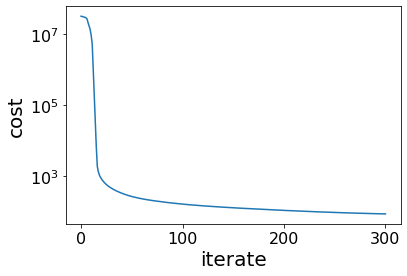

In [103]:
import matplotlib.pyplot as plt

plt.semilogy(cost_arr)
plt.xlabel('iterate')
plt.ylabel('cost')

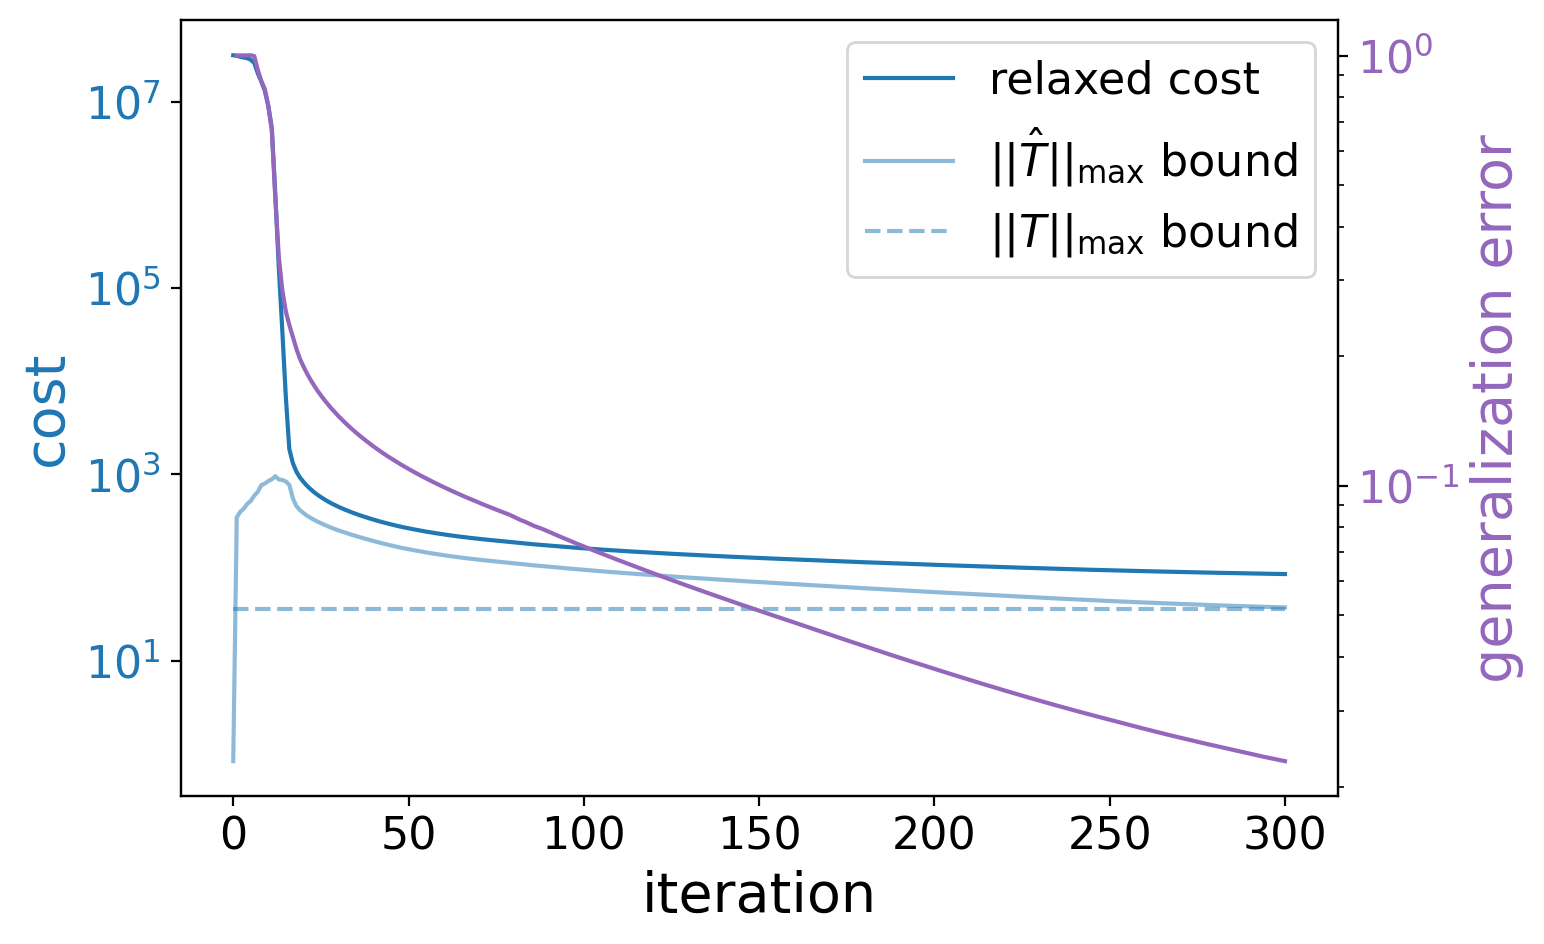

In [104]:
fig, ax1 = plt.subplots(figsize=(8,5), dpi=200)

color1 = 'tab:blue'
ax1.semilogy(cost_arr, '-', color=color1, label='relaxed cost')
ax1.semilogy(max_qnorm_arr, '-', label=r"$\|\| \hat{T} \|\|_{\rm max}$ bound", alpha=0.5)
ax1.hlines(qnorm_true, 0, len(cost_arr)-1, colors=color1, linestyle='dashed', alpha=0.5, label=r"$\|\| T \|\|_{\rm max}$ bound")
ax1.set_ylabel('cost', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend()

color2 = 'tab:purple'
ax2 = ax1.twinx()
ax2.semilogy(np.arange(1, len(gen_err_arr)), gen_err_arr[:-1], '-', color=color2)
ax2.set_ylabel('generalization error', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_xlabel('iteration')

fig.tight_layout()

plt.savefig("expander_result_iterations_t_%d_n_%d.png" % (t, n), transparent=False)

Text(0, 0.5, 'relative error')

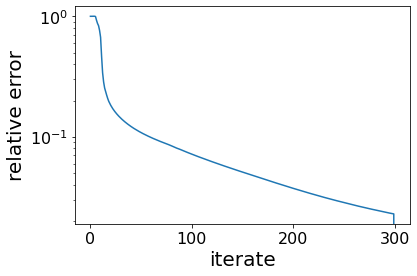

In [105]:
plt.semilogy(gen_err_arr)
plt.xlabel('iterate')
plt.ylabel('relative error')

## Generalization error

In [22]:
def gen_err(Upred, Utrue):
    norm_true = kr_dot(Utrue, Utrue)
    mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
    return np.sqrt(mse_gen / norm_true)

def mse_gen_err(Upred, Utrue):
    norm_true = kr_dot(Utrue, Utrue)
    mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
    return np.sqrt(mse_gen / Upred[0].shape[0] ** len(Upred))

print("relative RMSE max:      %1.4e" % gen_err(Unew2, U))
print("MSE max:                %1.4e" % mse_gen_err(Unew2, U))

relative RMSE max:      7.3712e-02
MSE max:                7.3712e-02


In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,t, figsize=(6, 20))
for i in range(t):
    im = axs[i].imshow(Unew2[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:
        axs[i].set_yticks([])

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(1,t, figsize=(6, 20))
for i in range(t):
    im = axs[i].imshow(U[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:
        axs[i].set_yticks([])